# **Emotion Prediction**

## **Powered by Leonardo Cofone**

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import shutil
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

In [5]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"
img_size = 160
batch_size = 64
seed = 42
import random
random.seed(seed) 

# Number of images per class before preprocessing

**This time I choose to don't make any OverSampling and simply remove the Disgust class, to se my other project see [here](https://www.kaggle.com/code/zlatan599/emotion-prediction)**

| Class ID | Class Name  | Number of Images |
|----------|-------------|------------------|
| 0        | Angry       | 3196             |
| 1        | Disgust     | 349              |
| 2        | Fear        | 3278             |
| 3        | Happy       | 5772             |
| 4        | Sad         | 3972             |
| 5        | Surprise    | 3864             |
| 6        | Neutral     | 2537             |

In [6]:
source_base = "/kaggle/input/fer2013"
target_base = "/kaggle/working/fer2013"

for subfolder in ["train", "test"]:
    src = os.path.join(source_base, subfolder)
    dst = os.path.join(target_base, subfolder)
    shutil.copytree(src, dst, dirs_exist_ok=True)

def remove_disgust_from_dir(base_dir, disgust_label='disgust'):
    disgust_path = os.path.join(base_dir, disgust_label)
    if os.path.exists(disgust_path):
        shutil.rmtree(disgust_path)
    else:
        print(f"Error")

train_dir = os.path.join(target_base, "train")
test_dir = os.path.join(target_base, "test")

remove_disgust_from_dir(train_dir)
remove_disgust_from_dir(test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    validation_split=0.15,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

def limit_class_images(source_dir, target_dir, max_per_class=4000):
    os.makedirs(target_dir, exist_ok=True)
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in class_names:
        src_cls_dir = os.path.join(source_dir, cls)
        dst_cls_dir = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)

        imgs = os.listdir(src_cls_dir)
        if len(imgs) > max_per_class:
            imgs = random.sample(imgs, max_per_class)

        for img in imgs:
            shutil.copy2(os.path.join(src_cls_dir, img), os.path.join(dst_cls_dir, img))

limited_train_dir = "/kaggle/working/fer2013_train_limited"
limit_class_images(train_dir, limited_train_dir, max_per_class=4000)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)

train_gen = train_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=seed
)

val_generator = val_test_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=seed
)

classes = np.array(train_gen.classes)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weight_dict = dict(enumerate(cw))

print("Class weights:", class_weight_dict)
print("Class distribution in the training set:", Counter(classes))

Found 7067 images belonging to 6 classes.
Found 19692 images belonging to 6 classes.
Found 3474 images belonging to 6 classes.
Class weights: {0: 0.9664310954063604, 1: 0.9652941176470589, 2: 0.9652941176470589, 3: 0.9652941176470589, 4: 0.9652941176470589, 5: 1.217359050445104}
Class distribution in the training set: Counter({1: 3400, 2: 3400, 3: 3400, 4: 3400, 0: 3396, 5: 2696})


## **TRAIN THE MODEL**

In [7]:
num_classes = 6

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752308338.124314      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    52,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,09

 Total params: 57,651,910 (219.92 MB)

 Trainable params: 57,646,918 (219.91 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [8]:
epochs = 60

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1752308360.432354     115 service.cc:148] XLA service 0x7853d0009990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752308360.433228     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752308361.304204     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752308385.604549     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1836 - loss: 37.2207
Epoch 1: val_loss improved from inf to 35.98184, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 126s 301ms/step - accuracy: 0.1836 - loss: 37.2162 - val_accuracy: 0.1727 - val_loss: 35.9818 - learning_rate: 1.0000e-04
Epoch 2/60
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1997 - loss: 31.2394
Epoch 2: val_loss improved from 35.98184 to 27.52236, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 63s 205ms/step - accuracy: 0.1998 - loss: 31.2343 - val_accuracy: 0.1966 - val_loss: 27.5224 - learning_rate: 1.0000e-04
Epoch 3/60
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2153 - loss: 25.0179
Epoch 3: val_loss improved from 27.52236 to 22.52559, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 63s 204ms/step - accuracy: 0.2152 - loss: 25.0134 - val_accuracy: 0.1678 - val_loss: 22.5256 - learning_rate: 1.0000e-04
Epoch 4/60
308/308 ━━━━━━━━━━━━━━━━━━

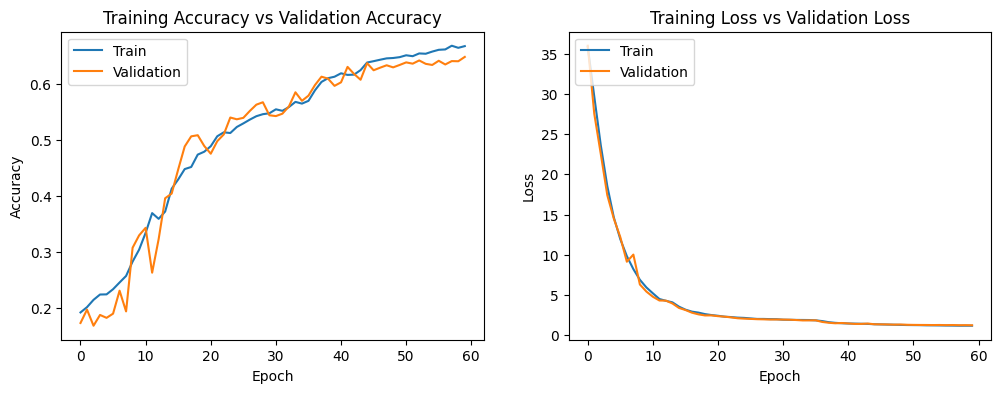

In [9]:
def plot_history(history):
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    fig.set_size_inches(12,4)
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)

## **TEST THE MODEL**

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.70      0.61       958
           1       0.52      0.40      0.45      1024
           2       0.91      0.83      0.87      1774
           3       0.60      0.66      0.63      1233
           4       0.55      0.50      0.52      1247
           5       0.73      0.84      0.78       831

    accuracy                           0.66      7067
   macro avg       0.64      0.65      0.64      7067
weighted avg       0.67      0.66      0.66      7067



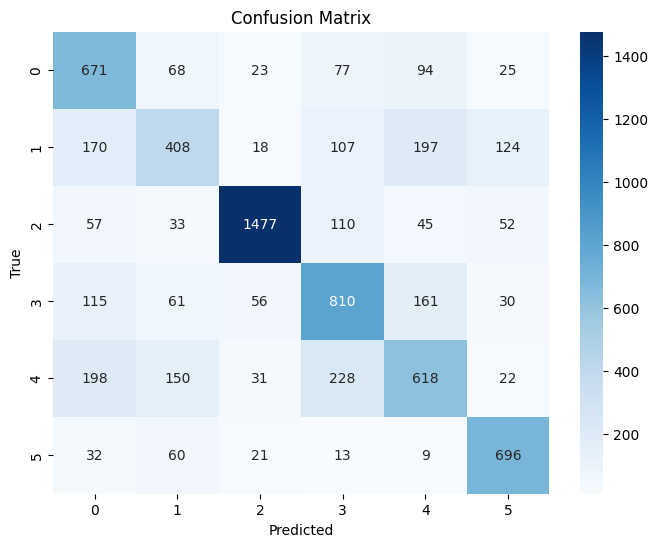

ROC AUC Score (macro): 0.9084
F1 Score (macro): 0.6438


In [15]:
steps = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    steps += 1

y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)

y_true = test_generator.classes

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(test_generator.num_classes))
    roc_auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
    print(f"ROC AUC Score (macro): {roc_auc:.4f}")
except Exception as e:
    print(f"ROC AUC calculation failed: {e}")

f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score (macro): {f1:.4f}")


In [16]:
def find_best_threshold(y_true, y_prob):
    best_thresh = 0.5
    best_f1 = 0.0
    for thresh in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        score = f1_score(y_true, y_pred)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

def compute_class_thresholds(y_true, y_probs, class_names):
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    thresholds = {}
    for i, name in enumerate(class_names):
        t, f1 = find_best_threshold(y_true_bin[:, i], y_probs[:, i])
        thresholds[name] = (round(t, 3), round(f1, 3))
    return thresholds

EMOTION_CLASSES = test_generator.class_indices.keys()
thresholds = compute_class_thresholds(y_true, y_pred_probs, list(EMOTION_CLASSES))

print("\nBest thresholds for every class (threshold, F1):")
for cls, (t, f1) in thresholds.items():
    print(f"{cls}: soglia = {t}, F1 = {f1}")


Soglie ottimali per classe (threshold, F1):
angry: soglia = 0.44, F1 = 0.623
fear: soglia = 0.22, F1 = 0.498
happy: soglia = 0.24, F1 = 0.876
neutral: soglia = 0.36, F1 = 0.63
sad: soglia = 0.24, F1 = 0.564
surprise: soglia = 0.64, F1 = 0.785


In [17]:
best_thresholds = {
    'angry': 0.44,
    'fear': 0.22,
    'happy': 0.24,
    'sad': 0.24,
    'surprise': 0.64,
    'neutral': 0.36
}

with open('best_thresholds.txt', 'w') as f:
    f.write("Classe\tSoglia\n")
    for emotion, thresh in best_thresholds.items():
        f.write(f"{emotion}\t{thresh:.2f}\n")

model.save('Emotion_detection_final2.h5')